In [1]:

import numpyro
import numpyro.distributions as dist
from matplotlib.legend import Legend
from numpyro.infer import MCMC, HMC
import numpyro.diagnostics as diagnostics

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

In [3]:
import arviz as az

In [4]:
from typing import Tuple, Sequence
from jax import jit, vmap, random

from functools import partial


@jit
def _sample_spherical_coords_inner(
    key,
    keys,
    n_samples,
    r_low,
    r_high,
    is_last_angle,
):
    """Inner function for sampling a single angle"""
    r = random.uniform(key, shape=(n_samples,), minval=r_low, maxval=r_high)
    max_val = jnp.where(is_last_angle, 2.0 * jnp.pi, jnp.pi)
    phi = random.uniform(keys, shape=(n_samples,), minval=0.0, maxval=max_val)
    return r, phi


@partial(jit, static_argnames=["n_dim", "n_samples"])
def sample_spherical_coords(
    key,
    n_dim,
    n_samples,
    r_low = 0.0,
    r_high = 1.0,
):
    """
    Generate uniform samples in n-dimensional spherical coordinates using JAX.

    Args:
        key: JAX random number generator key
        n_dim: Number of dimensions
        n_samples: Number of samples to generate
        r_low: Lower bound for radial coordinate
        r_high: Upper bound for radial coordinate

    Returns:
        Tuple containing:
        - Array of radial coordinates
        - Sequence of arrays containing angular coordinates
    """
    # Split the key for different random operations
    keys = random.split(key, n_dim)

    # Sample radial coordinate uniformly
    r = random.uniform(keys[0], shape=(n_samples,), minval=r_low, maxval=r_high)

    # Generate angular coordinates using vmap
    def sample_phi(key, is_last):
        max_val = jnp.where(is_last, 2.0 * jnp.pi, jnp.pi)
        return random.uniform(key, shape=(n_samples,), minval=0.0, maxval=max_val)

    # Create a list of boolean flags indicating if the angle is the last one
    is_last = jnp.arange(n_dim - 1) == (n_dim - 2)
    phis = vmap(sample_phi)(keys[1:], is_last)

    return r, phis


@jit
def spherical_to_cartesian(r, phis) :
    """
    Convert spherical coordinates to Cartesian coordinates using JAX.

    Args:
        r: Array of radial coordinates with shape (n_samples,)
        phis: Sequence of arrays containing angular coordinates,
              each with shape (n_samples,)

    Returns:
        Array of shape (n_samples, n_dim) containing Cartesian coordinates
    """

    n_dim = len(phis) + 1

    # Compute the Cartesian coordinates using vectorized operations
    sin_phis = jnp.sin(phis)
    cos_phis = jnp.cos(phis)

    # Initialize the Cartesian coordinates with the first coordinate
    x = r * cos_phis[0]

    # Compute the middle coordinates
    for i in range(1, n_dim - 1):
        x = jnp.column_stack((x, r * jnp.prod(sin_phis[:i], axis=0) * cos_phis[i]))

    # Compute the last coordinate
    last_coord = r * jnp.prod(sin_phis, axis=0)
    x = jnp.column_stack((x, last_coord))

    return x





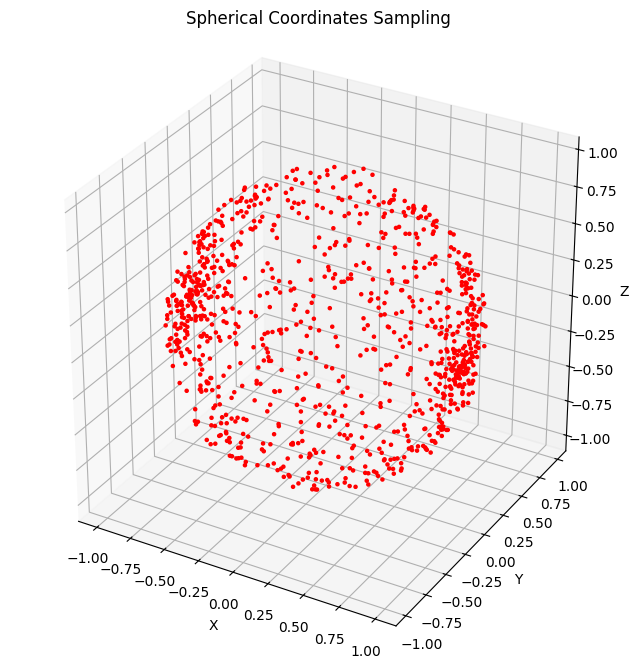

In [5]:
key = random.PRNGKey(42)

# Parameters
n_dim = 3  # Number of dimensions
n_samples = 1000  # Number of samples
r_low = 0.9  # Lower bound for radial coordinate
r_high = 1.0  # Upper bound for radial coordinate

# Generate samples
r, phis = sample_spherical_coords(key, n_dim, n_samples, r_low, r_high)

# Convert to Cartesian coordinates
x = spherical_to_cartesian(r, phis)
if n_dim <= 3:
    # Convert JAX arrays to NumPy for plotting
    x_np = jnp.asarray(x).copy()

    # Create the 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Create scatter plot
    scatter = ax.scatter(
        x_np[:, 0], x_np[:, 1], x_np[:, 2], alpha=1, c="red", marker="."
    )

    # Set labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Spherical Coordinates Sampling")

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    # Show the plot
    plt.show()
else:
    print("Sampling and conversion completed successfully!")

In [6]:
def sample_annuli(D, n_samples, args):
    key = random.PRNGKey(42)
    """
    Samples from the annuli with specified radius

    args tuple:
        - n_dims : dimension of samples
        - n_samples : number of samples to be drawn
        - r_low : lower bound for radius (inner radius)
        - r_high: upper bound for radius (outer radius)
    """
    if args == []:
        print(
            """
            You must pass in args. The format of the list is:
                - r_low : lower bound for radius (inner radius)
                - r_high: upper bound for radius (outer radius)
              """
        )
    else:
        r_low = args[0]  # Lower bound for radial coordinate
        r_high = args[1]  # Upper bound for radial coordinate

    # Set random seed for reproducibility


    # Generate samples
    r, phis = sample_spherical_coords(key, D, n_samples, r_low, r_high)

    # Convert to Cartesian coordinates
    samples = spherical_to_cartesian(r, phis)

    return samples

In [7]:
def generate_bounds(start=0, stop=1, length=0.33):
    arr = jnp.arange(start, stop, length, dtype=jnp.float16)
    pairs = [[arr[i], arr[i + 1]] for i in range(len(arr) - 1)]
    return pairs

mean of sample norms: 0.95073223
samples shape [n_samples , D]: (1000, 3)


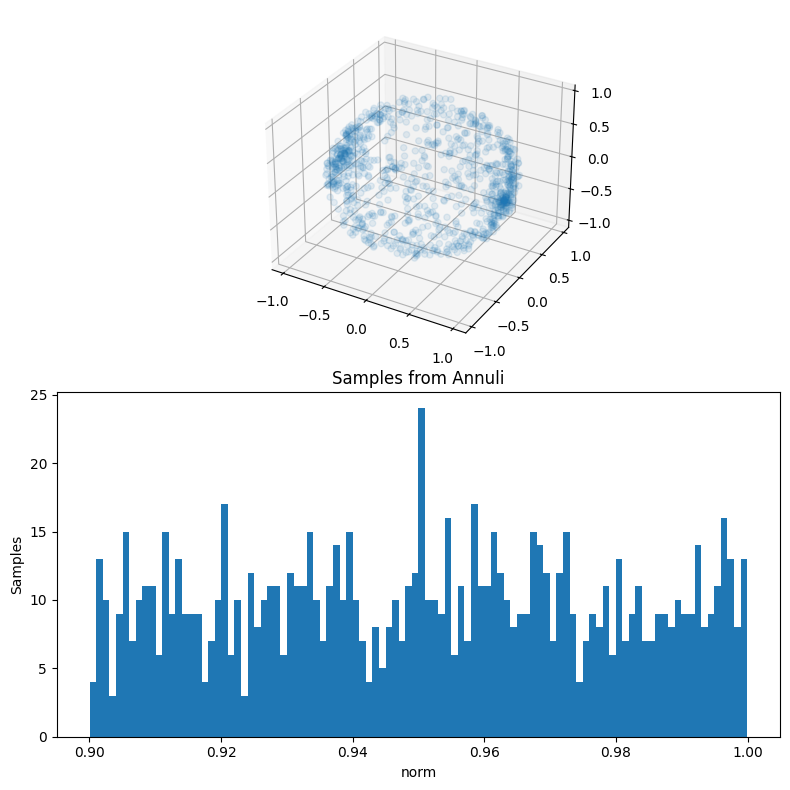

In [8]:
# Set random seed for reproducibility
key = random.PRNGKey(42)
samples = sample_annuli(D=3, n_samples=1000, args=[0.9, 1])
# Convert JAX arrays to NumPy for plotting
samples_np = jnp.asarray(samples).copy()
print("mean of sample norms:", jnp.mean(jnp.linalg.norm(samples, axis=1)))
print("samples shape [n_samples , D]:", samples.shape)
# Plot
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(211, projection="3d")
ax1.scatter(samples_np[:, 0], samples_np[:, 1], samples_np[:, 2], alpha=0.1)
ax2 = fig.add_subplot(212)
ax2.hist(jnp.linalg.norm(samples, axis=1), bins=100)
ax2.set_xlabel("norm")
ax2.set_ylabel("Samples")
plt.title("Samples from Annuli")
plt.tight_layout()
plt.show()

In [9]:
def logistic_posterior(X, y, D, prior_variance=1.0):
    # Parameter of interest: beta
    prior_var = prior_variance / jnp.sqrt(D)
    beta = numpyro.sample(
        "beta",
        dist.Normal(jnp.zeros(D), jnp.ones(D) * prior_var)
    )

    # Compute logits: beta.T @ X
    logits = jnp.dot(X, beta)

    # Deterministic site to track the probability p for each observation
    p = numpyro.deterministic("p", jax.scipy.special.expit(logits))

    # Likelihood: Y ~ Bern(p)
    numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)

In [10]:
def run_mcmc(logistic_posterior, y_obs, X_data, D,num_chains, num_iter, step_size, bound=[], rand_init=False):
    num_chains = num_chains
    if rand_init:
        #random init
        print("Random initialization")
        initial_beta = sample_annuli(D=D, n_samples=num_chains, args=bound)
    else:
        #deterministic init
        print("Deterministic initialization")
        initial_beta = jnp.zeros((num_chains,D))

    step_size = step_size

    kernel = HMC(
        logistic_posterior,
        step_size=step_size,
        trajectory_length=step_size, #num_leapfrog_steps = trajectory_length / step_size
        adapt_step_size=False #to make it mala
    )

    mcmc = MCMC(kernel,
                num_warmup=0,
                num_samples=num_iter,
                num_chains=num_chains)

    # --- Run Inference ---
    mcmc.run(k3,
             X=X_data,
             y=y_obs,
             D=D,
             init_params={"beta": initial_beta} # initialization
    )
    data = az.from_numpyro(mcmc)


    samples = mcmc.get_samples(group_by_chain=True)


    return samples, data



In [11]:
#data parms
N, D = 1000, 1000 # observations,  features
true_beta = jnp.zeros(D)

#mcmc parms
num_chains = 4
num_iter = 10000
step_size = 0.008

data_dict_rand = {}

#init parsm
rand_init = True
start = 0
stop = 1
interval_length = 0.33
bounds = generate_bounds(start=start, stop=stop, length=interval_length)


for i,bound in enumerate(bounds):

    bound_str = f"[{bound[0]:.1f}, {bound[1]:.2f}]"

    print(bound_str)
    rng_key = random.PRNGKey(0)
    k1, k2, k3 = random.split(rng_key, 3)

    #draw X features
    X_data = random.normal(k1, (N, D)) * jnp.sqrt(1/D)

    # Generate binary observations
    y_obs = dist.Bernoulli(logits=jnp.dot(X_data, true_beta)).sample(k2)

    #draw samples
    samples, azdata_random_init = run_mcmc(logistic_posterior, y_obs, X_data, D, num_chains, num_iter, step_size, bound, rand_init=rand_init)


    beta_samples = samples["beta"]
    p_samples = samples["p"] # This contains the inferred p for every observation


    data_dict_rand[bound_str] = [beta_samples, p_samples]




[0.0, 0.33]
Random initialization


/var/folders/52/zlgr2hdx7nb8f3m4970zr2v40000gn/T/ipykernel_4532/3733978795.py:21: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,
sample: 100%|██████████| 10000/10000 [00:04<00:00, 2402.92it/s, 1 steps of size 8.00e-03. acc. prob=0.95]


[0.3, 0.66]
Random initialization


sample: 100%|██████████| 10000/10000 [00:04<00:00, 2361.88it/s, 1 steps of size 8.00e-03. acc. prob=0.95]


[0.7, 0.99]
Random initialization


sample: 100%|██████████| 10000/10000 [00:03<00:00, 2763.96it/s, 1 steps of size 8.00e-03. acc. prob=0.95]


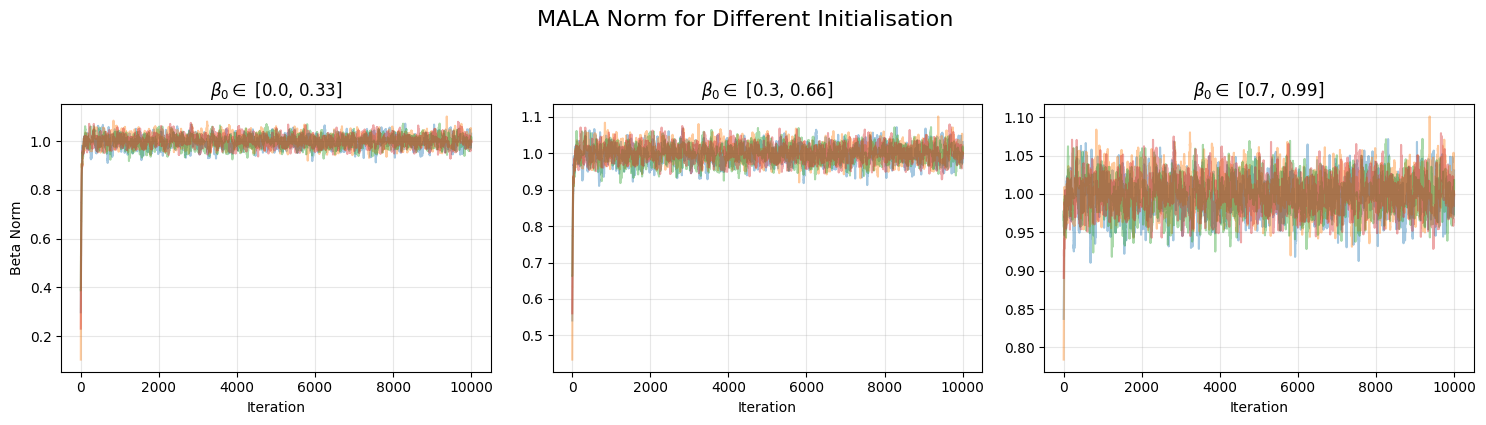

In [87]:
keys = list(data_dict_rand.keys())
num_plots = len(keys)

fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 4), squeeze=False)

for i, key in enumerate(keys):
    # Get samples
    beta_samples = data_dict_rand[key][0]
    beta_norms = jnp.linalg.norm(beta_samples, axis=-1)

    ax = axes[0, i]
    ax.plot(beta_norms.T, alpha=0.4)
    ax.set_title(rf"$\beta_{{0}} \in$ {key}")
    ax.set_xlabel("Iteration")
    ax.grid(True, alpha=0.3)

# Label the first y-axis only to keep it clean
axes[0, 0].set_ylabel("Beta Norm")

fig.suptitle("MALA Norm for Different Initialisation", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

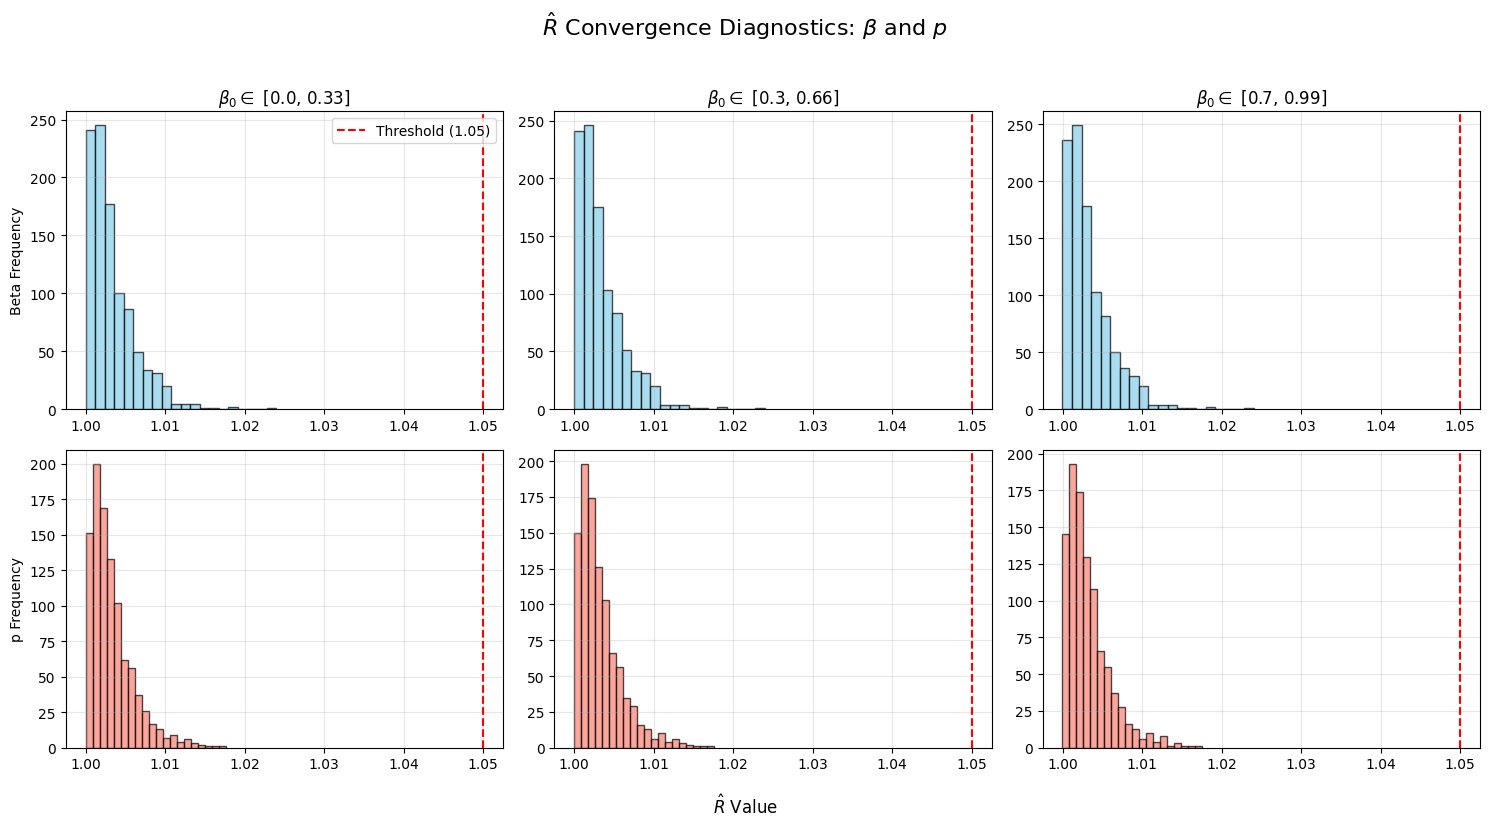

In [88]:


keys = list(data_dict_rand.keys())
num_plots = len(keys)

fig, axes = plt.subplots(2, num_plots, figsize=(5 * num_plots, 8), squeeze=False)

for i, key in enumerate(keys):
    #Beta Samples
    beta_samples = data_dict_rand[key][0]
    beta_r_hat = diagnostics.gelman_rubin(beta_samples)

    ax_beta = axes[0, i]
    ax_beta.hist(beta_r_hat, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax_beta.set_title(rf"$\beta_{{0}} \in$ {key}")
    ax_beta.axvline(1.05, color='red', linestyle='--')
    ax_beta.grid(True, alpha=0.3)

    #p Samples
    p_samples = data_dict_rand[key][1]
    p_r_hat = diagnostics.gelman_rubin(p_samples)

    ax_p = axes[1, i]
    ax_p.hist(p_r_hat, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    ax_p.axvline(1.05, color='red', linestyle='--')
    ax_p.grid(True, alpha=0.3)


axes[0, 0].set_ylabel("Beta Frequency")
axes[1, 0].set_ylabel("p Frequency")

axes[0, 0].legend(['Threshold (1.05)'], loc='upper right')
fig.supxlabel(r"$\hat{R}$ Value")
fig.suptitle(r"$\hat{R}$ Convergence Diagnostics: $\beta$ and $p$", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

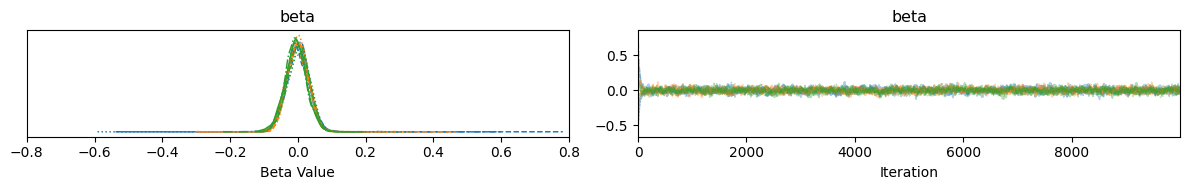

In [16]:
axes = az.plot_trace(azdata_random_init,var_names=["beta"], coords={"beta_dim_0": [0, 1, 2]}, compact=True)
axes[0, 0].set_xlim(-0.8, 0.8)
axes[0, 0].set_xlabel("Beta Value")


axes[0, 1].set_xlabel("Iteration")
plt.tight_layout()
plt.show()

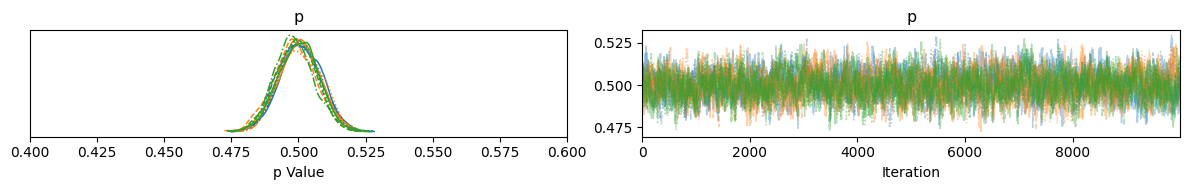

In [17]:
axes = az.plot_trace(azdata_random_init,var_names=["p"], coords={"p_dim_0": [0, 1, 2]}, compact=True)
axes[0, 0].set_xlim(0.4, 0.6)
axes[0, 0].set_xlabel("p Value")

axes[0, 1].set_xlabel("Iteration")
plt.tight_layout()
plt.show()

In [18]:
#data parms
N, D = 1000, 1000 # observations,  features
true_beta = jnp.zeros(D)

#mcmc parms
num_chains = 4
num_iter = 50000
step_size = 0.000001

data_dict_det = {}



rng_key = random.PRNGKey(0)
k1, k2, k3 = random.split(rng_key, 3)
#draw X features
X_data = random.normal(k1, (N, D)) * jnp.sqrt(1/D)

# Generate binary observations
y_obs = dist.Bernoulli(logits=jnp.dot(X_data, true_beta)).sample(k2)

#draw samples
samples, azdata_true_init = run_mcmc(logistic_posterior, y_obs, X_data, D, num_chains, num_iter, step_size)


beta_samples = samples["beta"]
p_samples = samples["p"] # This contains the inferred p for every observation


data_dict_det["deterministic"] = [beta_samples, p_samples]


/var/folders/52/zlgr2hdx7nb8f3m4970zr2v40000gn/T/ipykernel_4532/3733978795.py:21: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel,


Deterministic initialization


sample: 100%|██████████| 50000/50000 [00:18<00:00, 2660.19it/s, 1 steps of size 1.00e-06. acc. prob=1.00]


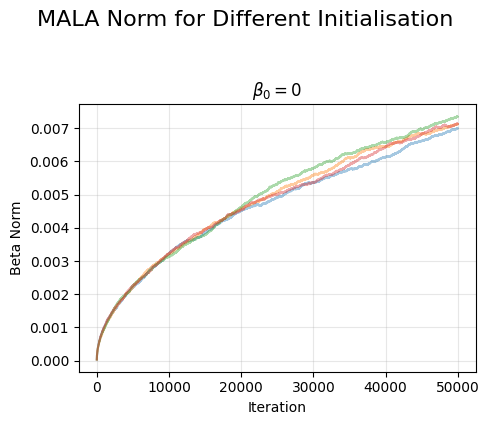

In [89]:
keys = list(data_dict_det.keys())
num_plots = len(keys)

fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 4), squeeze=False)

for i, key in enumerate(keys):
    # Get samples
    beta_samples = data_dict_det[key][0]
    beta_norms = jnp.linalg.norm(beta_samples, axis=-1)
    ax = axes[0, i]

    ax.plot(beta_norms.T, alpha=0.4)
    ax.set_title(rf"$\beta_{{0}}=0$")
    ax.set_xlabel("Iteration")
    ax.grid(True, alpha=0.3)

axes[0, 0].set_ylabel("Beta Norm")

fig.suptitle("MALA Norm for Different Initialisation", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

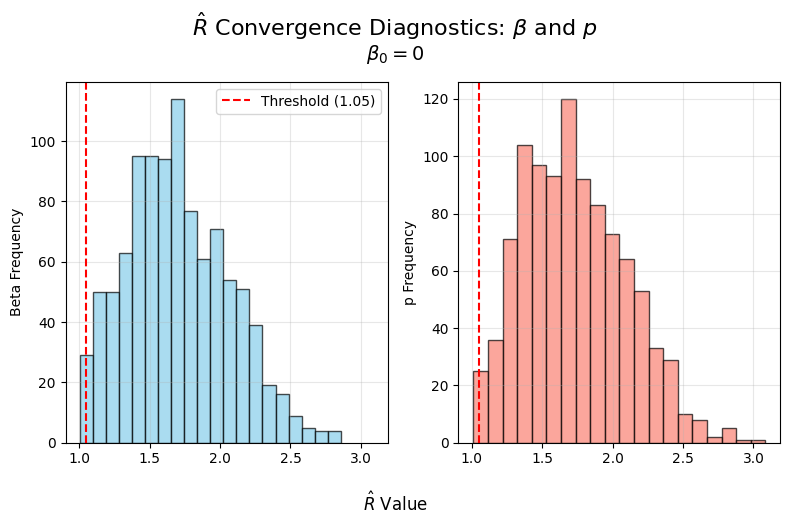

In [93]:
keys = list(data_dict_det.keys())
num_plots = len(keys)

fig, axes = plt.subplots(num_plots, 2, figsize=(8,5 * num_plots), squeeze=False, sharex=True)

for i, key in enumerate(keys):
    #Beta Samples
    beta_samples = data_dict_det[key][0]
    beta_r_hat = diagnostics.gelman_rubin(beta_samples)

    ax_beta = axes[0, 0]
    ax_beta.hist(beta_r_hat, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    ax_beta.axvline(1.05, color='red', linestyle='--')
    ax_beta.grid(True, alpha=0.3)

    #p Samples
    p_samples = data_dict_det[key][1]
    p_r_hat = diagnostics.gelman_rubin(p_samples)

    ax_p = axes[0,1]
    ax_p.hist(p_r_hat, bins=20, color='salmon', edgecolor='black', alpha=0.7)
    ax_p.axvline(1.05, color='red', linestyle='--')
    ax_p.grid(True, alpha=0.3)


axes[0, 0].set_ylabel("Beta Frequency")
axes[0, 1].set_ylabel("p Frequency")

axes[0, 0].legend(['Threshold (1.05)'], loc='upper right')
fig.text(0.5, 0.92, rf"$\beta_{{0}} = 0$", ha='center', fontsize=14)
fig.supxlabel(r"$\hat{R}$ Value")
fig.suptitle(r"$\hat{R}$ Convergence Diagnostics: $\beta$ and $p$", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


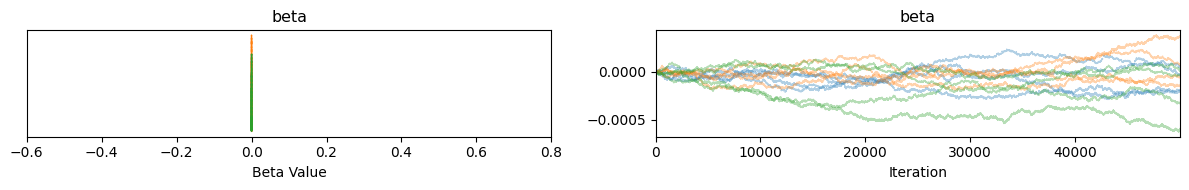

In [21]:
axes = az.plot_trace(azdata_true_init,var_names=["beta"], coords={"beta_dim_0": [0, 1, 2]}, compact=True)
axes[0, 0].set_xlim(-0.6, 0.8)
axes[0, 0].set_xlabel("Beta Value")


axes[0, 1].set_xlabel("Iteration")
plt.tight_layout()
plt.show()

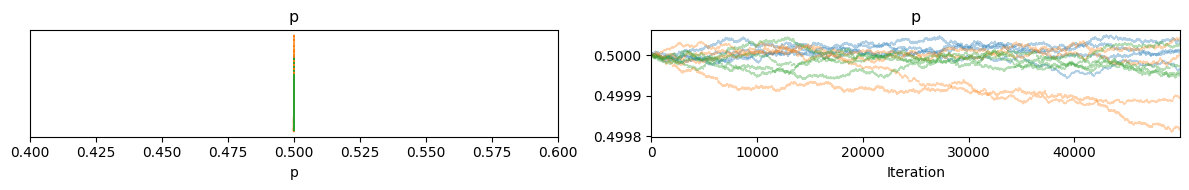

In [22]:
axes = az.plot_trace(azdata_true_init,var_names=["p"], coords={"p_dim_0": [0, 1, 2]}, compact=True)
axes[0, 0].set_xlim(0.4, 0.6)
axes[0, 0].set_xlabel("p")


axes[0, 1].set_xlabel("Iteration")
plt.tight_layout()
plt.show()

# Comparison Plots Grouped Tgt

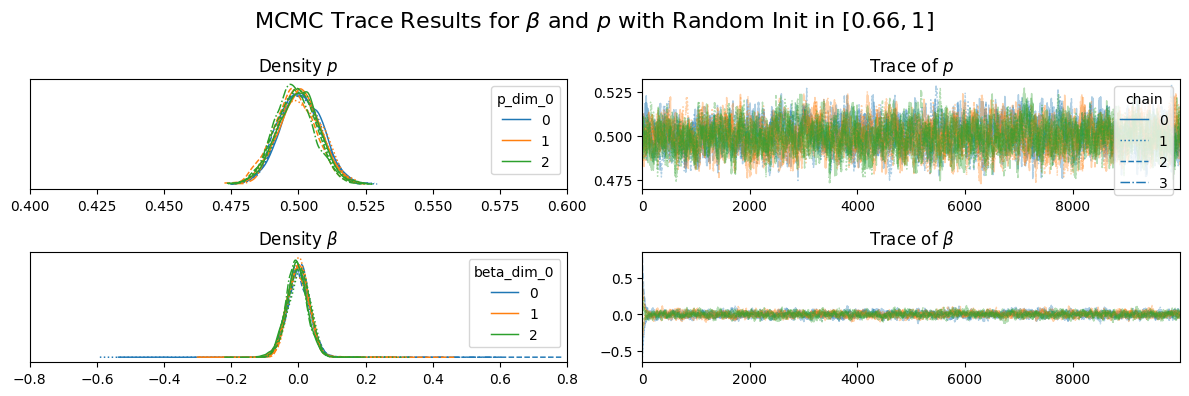

In [23]:
axes = az.plot_trace(azdata_random_init,var_names=["p", "beta"], coords={"p_dim_0": [0, 1, 2],"beta_dim_0": [0, 1, 2]}, compact=True, legend=True)
axes[0, 0].set_xlim(0.4, 0.6)
axes[1, 0].set_xlim(-0.8, 0.8)
axes[0, 0].set_title(r"Density $p$")
axes[0, 1].set_title(r"Trace of $p$")
axes[1, 0].set_title(r"Density $\beta$")
axes[1, 1].set_title(r"Trace of $\beta$")
plt.suptitle(r"MCMC Trace Results for $\beta$ and $p$ with Random Init in $[0.66,1]$ ", fontsize=16)
plt.tight_layout()
plt.show()

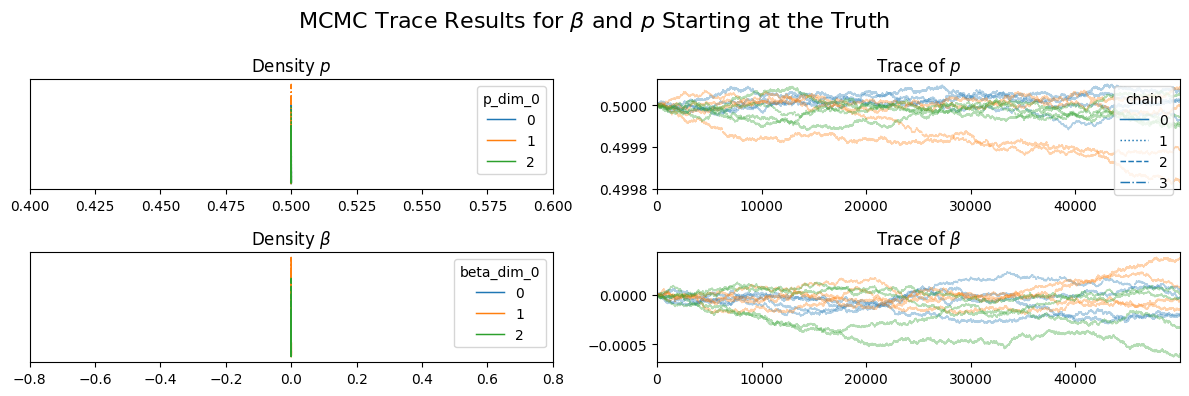

In [24]:
axes = az.plot_trace(azdata_true_init,var_names=["p", "beta"], coords={"p_dim_0": [0, 1, 2],"beta_dim_0": [0, 1, 2]}, compact=True, legend=True)
axes[0, 0].set_xlim(0.4, 0.6)
axes[1, 0].set_xlim(-0.8, 0.8)
axes[0, 0].set_title(r"Density $p$")
axes[0, 1].set_title(r"Trace of $p$")
axes[1, 0].set_title(r"Density $\beta$")
axes[1, 1].set_title(r"Trace of $\beta$")



plt.suptitle(r"MCMC Trace Results for $\beta$ and $p$ Starting at the Truth ", fontsize=16)
plt.tight_layout()
plt.show()

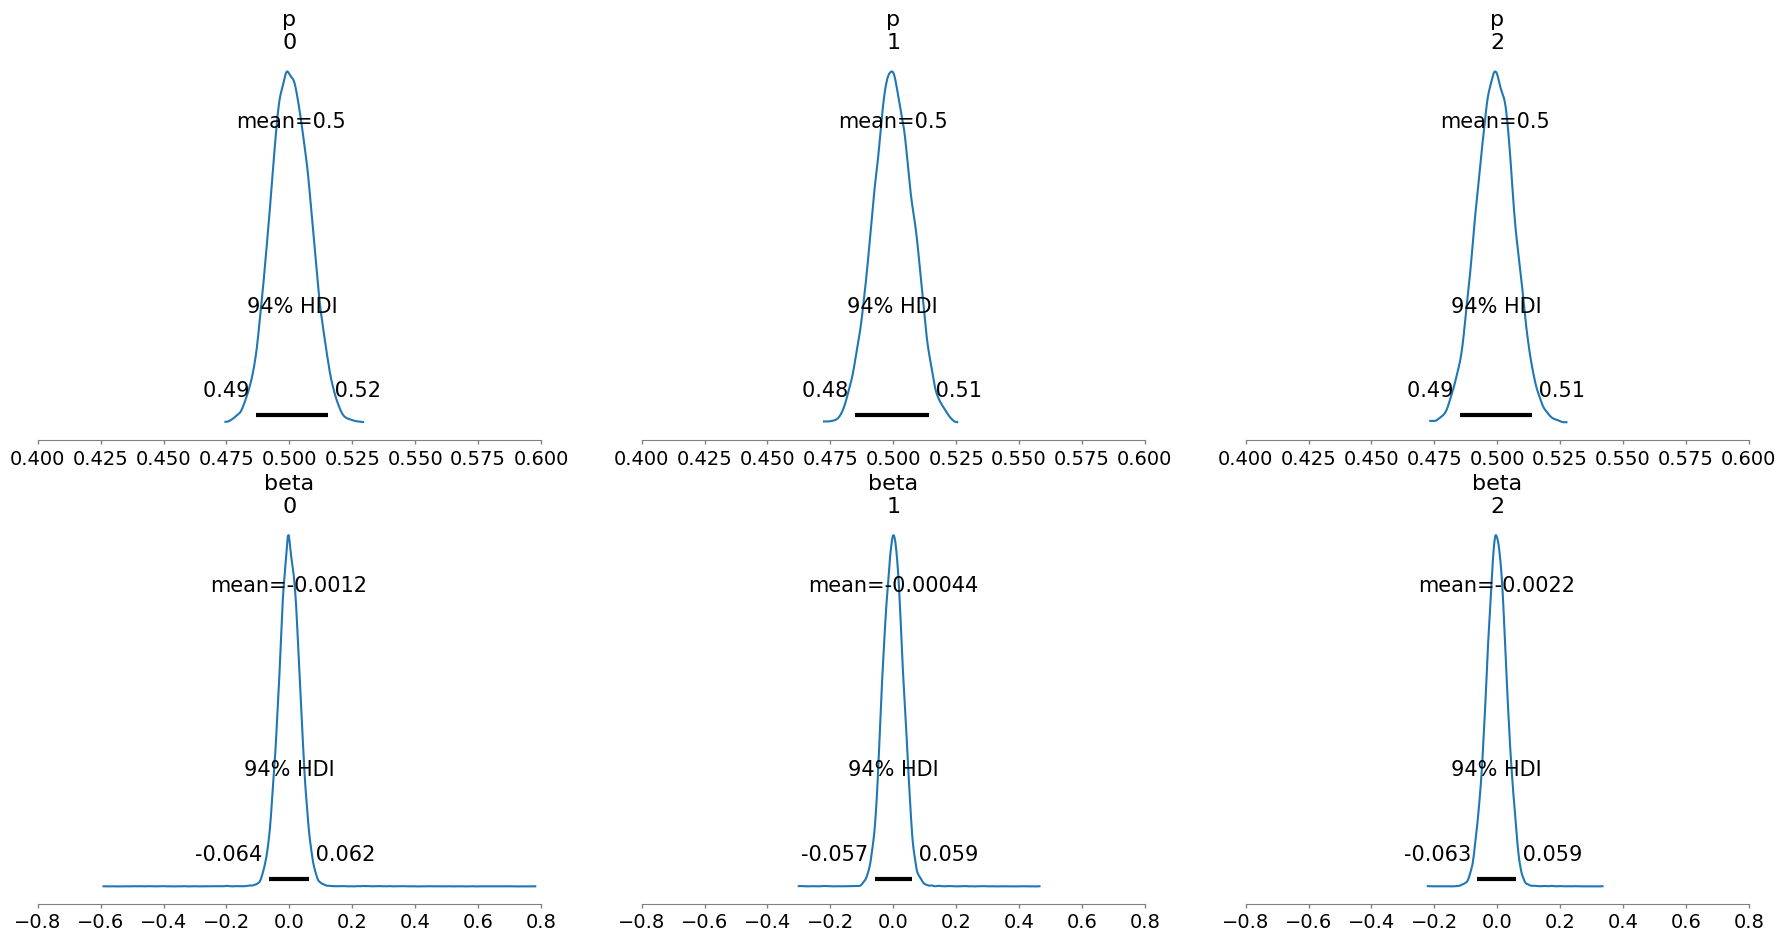

In [25]:

axes = az.plot_posterior(azdata_random_init,var_names=["p", "beta"], coords={"p_dim_0": [0, 1, 2],"beta_dim_0": [0, 1, 2]})
for ax in axes.flatten()[:3]:
    ax.set_xlim(0.4, 0.6)

# Next 3 plots (beta[0], beta[1], beta[2])
for ax in axes.flatten()[3:]:
    ax.set_xlim(-0.8, 0.8)


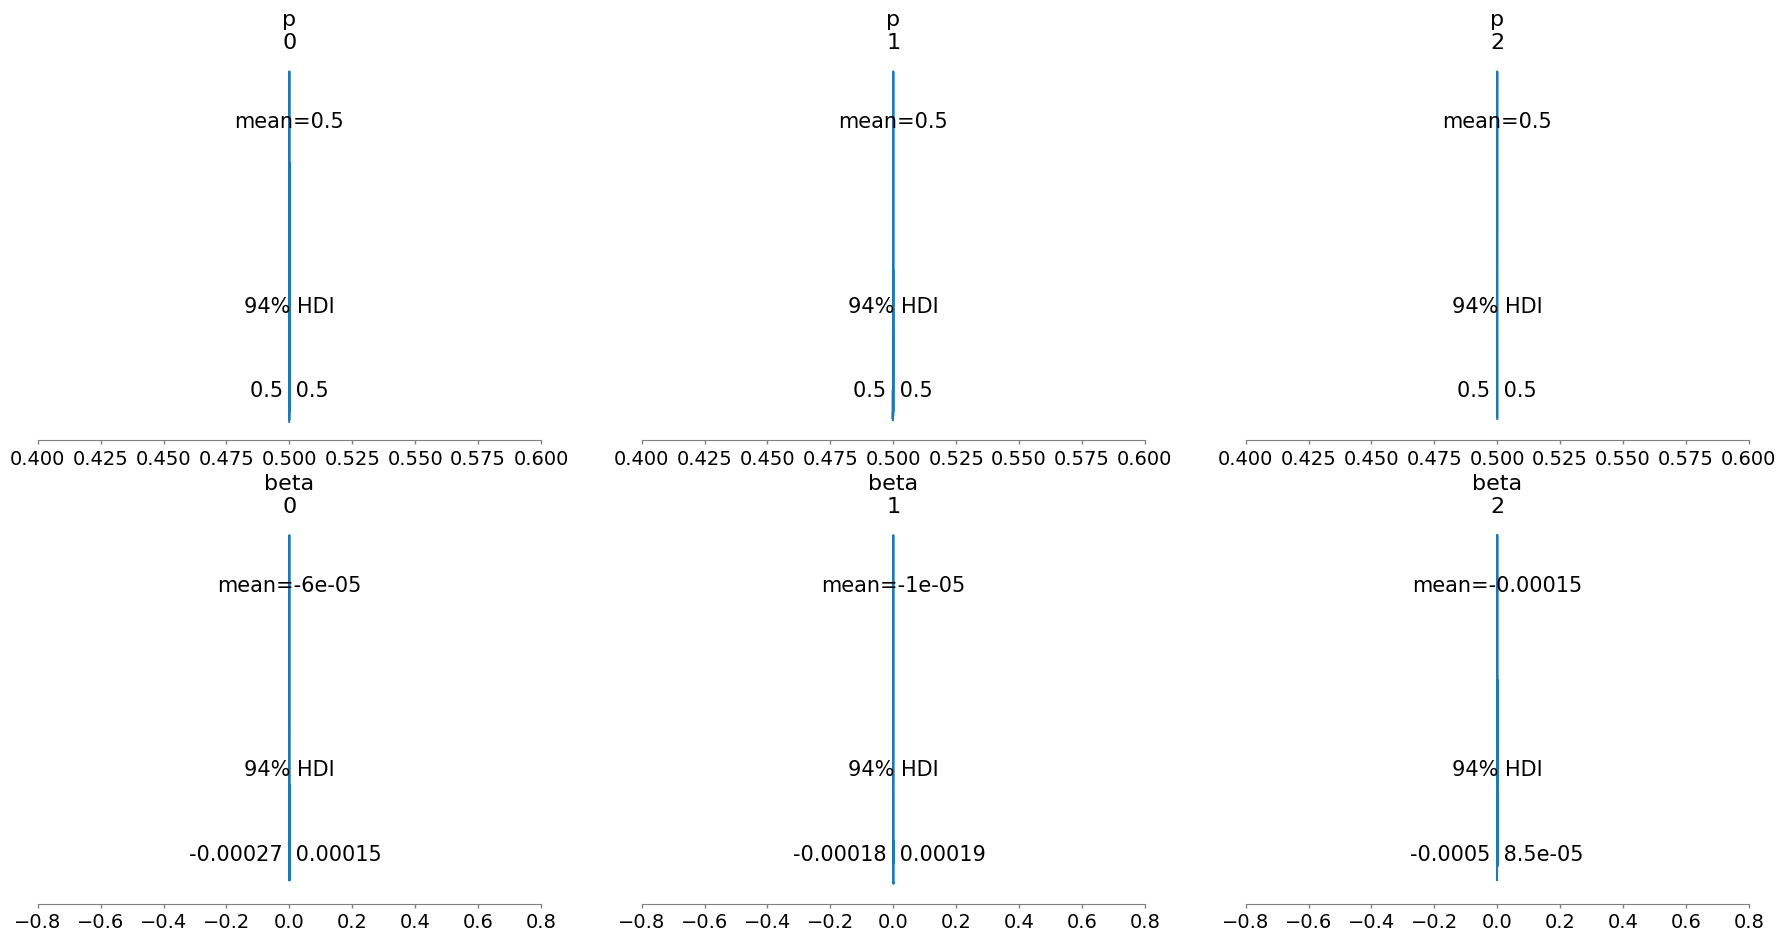

In [26]:
axes = az.plot_posterior(azdata_true_init,var_names=["p", "beta"], coords={"p_dim_0": [0, 1, 2],"beta_dim_0": [0, 1, 2]})
for ax in axes.flatten()[:3]:
    ax.set_xlim(0.4, 0.6)

# Next 3 plots (beta[0], beta[1], beta[2])
for ax in axes.flatten()[3:]:
    ax.set_xlim(-0.8, 0.8)
